In [1]:
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Verdana']
rcParams['font.size'] = 12
rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import phoebe
from matplotlib.ticker import FormatStrFormatter

cs = {'blue': '#2b71b1', 'orange': '#ff702f', 'green': '#22b77f', 'red': '#f92e3d', 'black': '#131313'}

In [8]:
def bundle_get_dists(bundle_file, mcmc_file, burnin=5000, thin=1, lnprob_cutoff = -np.inf, plot=False):
    b = phoebe.load('data/'+bundle_file+'.bundle')
    b.import_solution(r'data/%s.py.out.progress' % mcmc_file, solution='mcmc_solution')
    if plot:
        afig, mplfig = b.plot(solution='mcmc_solution', style='lnprobability', s=0.005, show=True)
    params = b.get_value('fitted_twigs', context='solution', solution='mcmc_solution')
    dists = b.uncertainties_from_distribution_collection(solution='mcmc_solution', 
                                                         burnin=burnin, 
                                                         thin=thin, 
                                                         lnprob_cutoff = lnprob_cutoff,
                                                         tex=False)
    mean_vals = dists[:,1]
    lower_errs = dists[:,1]-dists[:,0]
    upper_errs = dists[:,2]-dists[:,1]
    return b, {'twigs': params, 'means': mean_vals, 'errs': np.array([lower_errs, upper_errs]).T}

def bundle_get_true(bundle_file, params):
    b = phoebe.load('data/'+bundle_file+'.bundle')
    b.add_constraint('requivsumfrac')
    b.add_constraint('requivratio')
    b.add_constraint('teffratio')
    b.flip_constraint('teffratio', solve_for='teff@secondary')
    b.flip_constraint('requivsumfrac', solve_for='requiv@secondary')
    b.flip_constraint('requivratio', solve_for='requiv@primary')
    b.flip_constraint('esinw', solve_for='ecc')
    b.flip_constraint('ecosw', solve_for='per0')
    b.flip_constraint('q', solve_for='mass@secondary')
    true_vals = np.zeros(len(params))
    for i, param in enumerate(params):
        true_vals[i] = b.get_value(param)
        
    return true_vals

def plot_xsection(ax, param1, param2, true_vals, basic, marg, legend=False):
    # get the indices of the parameter values in each solution array
    i1 = np.argwhere(basic['twigs']==param1).flatten()[0]
    j1 = np.argwhere(basic['twigs']==param2).flatten()[0]
    i2 = np.argwhere(marg['twigs']==param1).flatten()[0]
    j2 = np.argwhere(marg['twigs']==param2).flatten()[0]
    
    ax.scatter(true_vals[i1], true_vals[j1], marker='x', s=100, c=cs['black'], label='true')
    
    for i,j,sol,c,label in zip([i1,i2],
                             [j1,j2],
                             [basic,marg],
                            [cs['blue'], cs['green']],
                              ['no marginalization', 'with marginalization']):
        ax.errorbar(x=sol['means'][i], y=sol['means'][j], 
                    xerr=[[sol['errs'][i][0]], [sol['errs'][i][1]]], 
                    yerr=[[sol['errs'][j][0]], [sol['errs'][j][1]]], 
                    fmt='o', ms=10, ls='none', c=c, label=label)
    
    if legend:
        ax.legend(loc='upper left')
        
        
    return ax

def compute_y(solution, true, i):
    return 100*np.abs((solution['means'][i]-true[i])/(true[i]))

def plot_solution(ax, labels, true, mcmc_near, mcmc_far, ylabel=False):
    
    s=50
    
    xs = np.arange(1, len(labels)+1, 1).astype(int)
    scatter_dict = {'x': [], 'y': [], 'fc': [], 'ec': [],}

    for i,x in enumerate(xs):
        scatter_dict['x'] += [x, x]
        scatter_dict['fc'] += [cs['blue'], 'none']
        scatter_dict['ec'] += [cs['blue'], cs['red']]
        scatter_dict['y'] += [compute_y(mcmc_near, true, i),
                              compute_y(mcmc_far, true, i)]                                                   
        
    ax.scatter(scatter_dict['x'][0], scatter_dict['y'][0], marker='o', 
           s=50, 
           facecolors=scatter_dict['fc'][0],
           edgecolors=scatter_dict['ec'][0], label='good init. sample')
    ax.scatter(scatter_dict['x'][1], scatter_dict['y'][1], marker='o', 
           s=50, 
           facecolors=scatter_dict['fc'][1],
           edgecolors=scatter_dict['ec'][1], label='bad init. sample')


    ax.scatter(scatter_dict['x'], scatter_dict['y'], marker='o', 
               s=50, 
               facecolors=scatter_dict['fc'],
               edgecolors=scatter_dict['ec'])
        
    ax.margins(0.2)
    ax.grid(linestyle=':', linewidth='0.5', color='#131313', alpha=0.75)
    for gl in ax.get_xgridlines():
        gl.set_color(cs['black'])
        gl.set_linewidth(1)
        gl.set_linestyle('--')
    ax.set_xticks(xs)
    ax.set_xticklabels(labels)
    ax.set_ylabel('parameter \% error')
    ax.legend()
#     ax.set_title(title) 
    return ax, scatter_dict


### GOOD VS BAD INIT

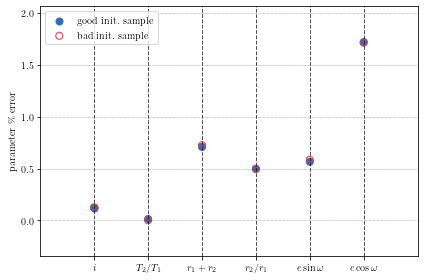

In [9]:
# b_ce_gi, ce_gi = bundle_get_dists('ce_goodinit_dists', 'ce_goodinit_0', plot=False)
# b_ce_bi, ce_bi = bundle_get_dists('ce_badinit_dists', 'ce_badinit_0', plot=False)
# true_vals_ce = bundle_get_true('d_ce', ce_gi['twigs'])

b_we_gi, we_gi = bundle_get_dists('we_nm_seq', 'we_goodinit_0', plot=False)
b_we_bi, we_bi = bundle_get_dists('we_nm_gs', 'we_badinit_0', lnprob_cutoff=6380, plot=False)
true_vals_we = bundle_get_true('d_we', we_gi['twigs'])

labels = ['$i$', '$T_{2}/T_{1}$', '$r_1+r_2$', '$r_2/r_1$', '$e\sin\omega$', '$e\cos\omega$']
params = we_gi['twigs']
fig, ax = plt.subplots(figsize=(6,4))
plot_solution(ax, labels, true_vals_we, we_gi, we_bi, ylabel=True)
fig.tight_layout()
fig.savefig('we_good_vs_bad_init.png', dpi=300)
plt.show()
%matplotlib inline
# afig, mplfig = b_we_bi.plot(solution='mcmc_solution', style='lnprobability', save='lnprob_we_bi.pdf', show=True)
# mplfig.savefig('lnprob_we_bi.png', dpi=300)
# afig, mplfig = b_we_gi.plot(solution='mcmc_solution', style='lnprobability', save='lnprob_we_gi.pdf', show=True)
# mplfig.savefig('lnprob_we_gi.png', dpi=300)

In [189]:
# mplfig.axes[0].set_xlim(-10,800)
# mplfig.axes[0].set_ylim(6300, 6400)
# mplfig.savefig('we_gi_lnprob_zoomed_in.png', dpi=300)

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


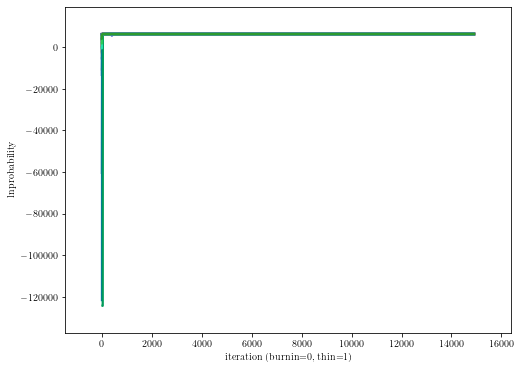

(<matplotlib.patches.Rectangle at 0x7f60cc31f110>,
 (<matplotlib.patches.ConnectionPatch at 0x7f60c4158110>,
  <matplotlib.patches.ConnectionPatch at 0x7f606f2dc590>))

In [216]:
b_we_gi, we_gi = bundle_get_dists('we_nm_seq', 'we_goodinit_0', plot=False)
afig, mplfig = b_we_gi.plot(solution='mcmc_solution', style='lnprobability', show=True)

ax = mplfig.axes[0]
from phoebe.dependencies.autofig.cyclers import _mplcolors
from cycler import cycler
custom_cycler = (cycler(color=_mplcolors))

axins = ax.inset_axes([0.25, 0.1, 0.7, 0.7])
axins.set_prop_cycle(custom_cycler)
axins.plot(b_we_gi['value@lnprobabilities'])
# sub region of the original image
x1, x2, y1, y2 = -10, 900, 6300, 6400
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins)

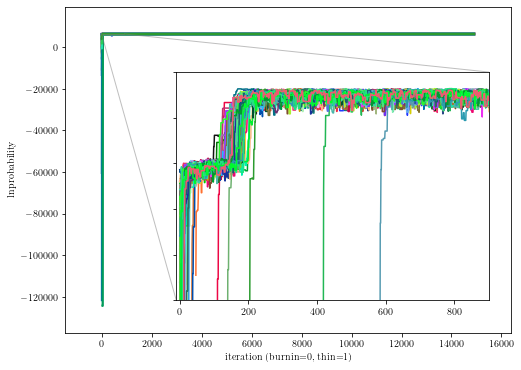

In [217]:
mplfig

In [218]:
mplfig.savefig('lnprob_we_gi.png', dpi=300)

In [152]:
%matplotlib qt
afig, mplfig = b_we_bi.plot(solution='mcmc_solution', style='lnprobability', s=0.005, show=True)

In [150]:
print(b_we_bi['distribution'])

ParameterSet: 0 parameters
NO PARAMETERS


### MARGINALIZATION

In [15]:
#!scp angela@terra.villanova.edu:fitting/phoetting_paper/AAS_ellcbnd/*.py.out.progress data/

In [69]:
%matplotlib inline
#ce_gi_basic = bundle_get_dists('ce_goodinit_dists', 'ce_goodinit_0', plot=False)

In [70]:
#ce_gi_marg = bundle_get_dists('ce_goodinit_dists', 'ce_goodinit_teff1_sma_q_p_t0', lnprob_cutoff=3145, plot=False)

In [219]:
b_ce_basic, ce_basic = bundle_get_dists('ce_badinit_dists', 'ce_badinit_0', plot=False)

In [220]:
b_ce_marg, ce_marg = bundle_get_dists('ce_badinit_dists', 'ce_badinit_teff1_sma_q_p_t0', lnprob_cutoff=3145, plot=False)

In [221]:
true_vals = bundle_get_true('d_ce', ce_basic['twigs'])

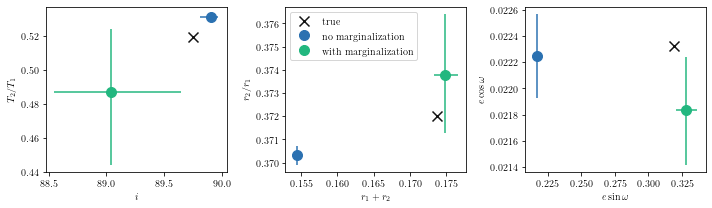

In [222]:
params = ce_basic['twigs']
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
plot_xsection(ax1, params[0], params[1], 
              true_vals, ce_basic, ce_marg)
plot_xsection(ax2, params[2], params[3], 
              true_vals, ce_basic, ce_marg, legend=True)
plot_xsection(ax3, params[4], params[5], 
              true_vals, ce_basic, ce_marg)
ax1.set_xlabel('$i$')
ax1.set_ylabel('$T_2/T_1$')
ax2.set_xlabel('$r_1+r_2$')
ax2.set_ylabel('$r_2/r_1$')
ax3.set_xlabel('$e\sin\omega$')
ax3.set_ylabel('$e\cos\omega$')
fig.tight_layout()
fig.savefig('figs/ce_marginalization.png', dpi=300)

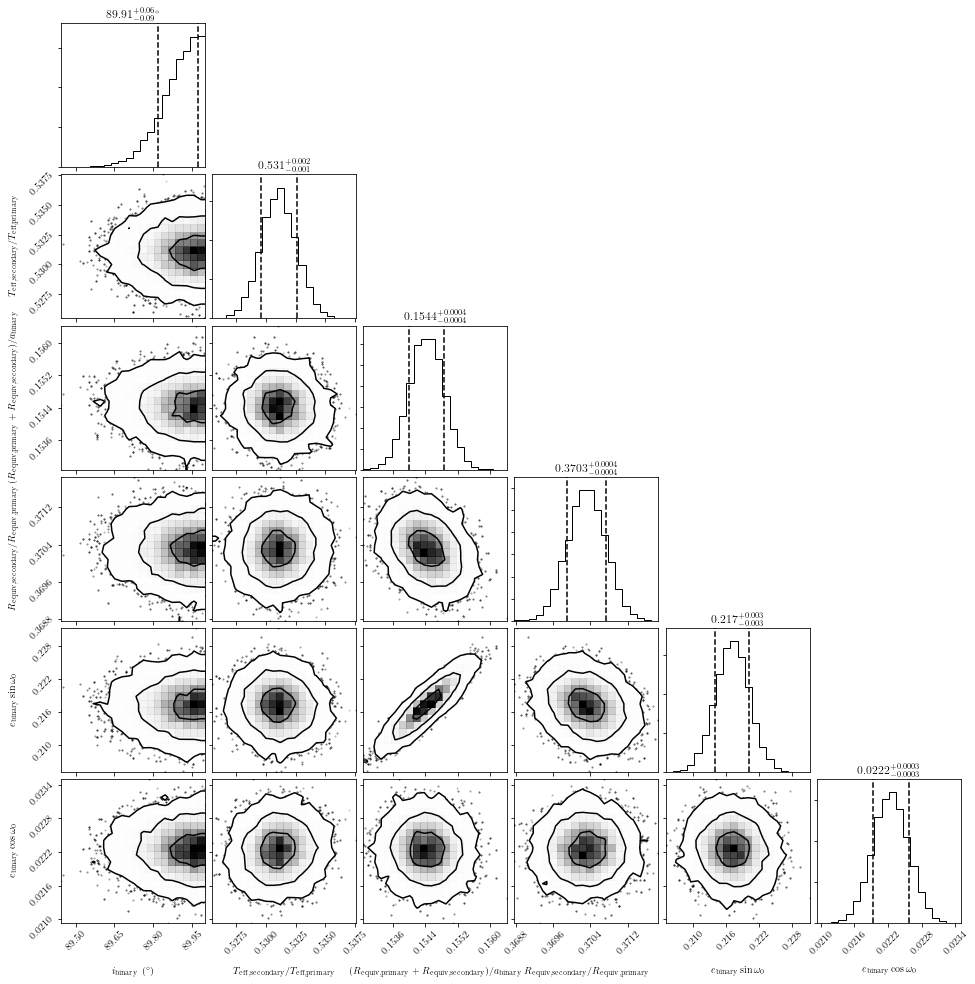

In [223]:
afig, mplfig = b_ce_basic.plot(solution='mcmc_solution', style='corner', burnin=10000, show=True)
mplfig.savefig('ce_basic_corner.png', dpi=300)

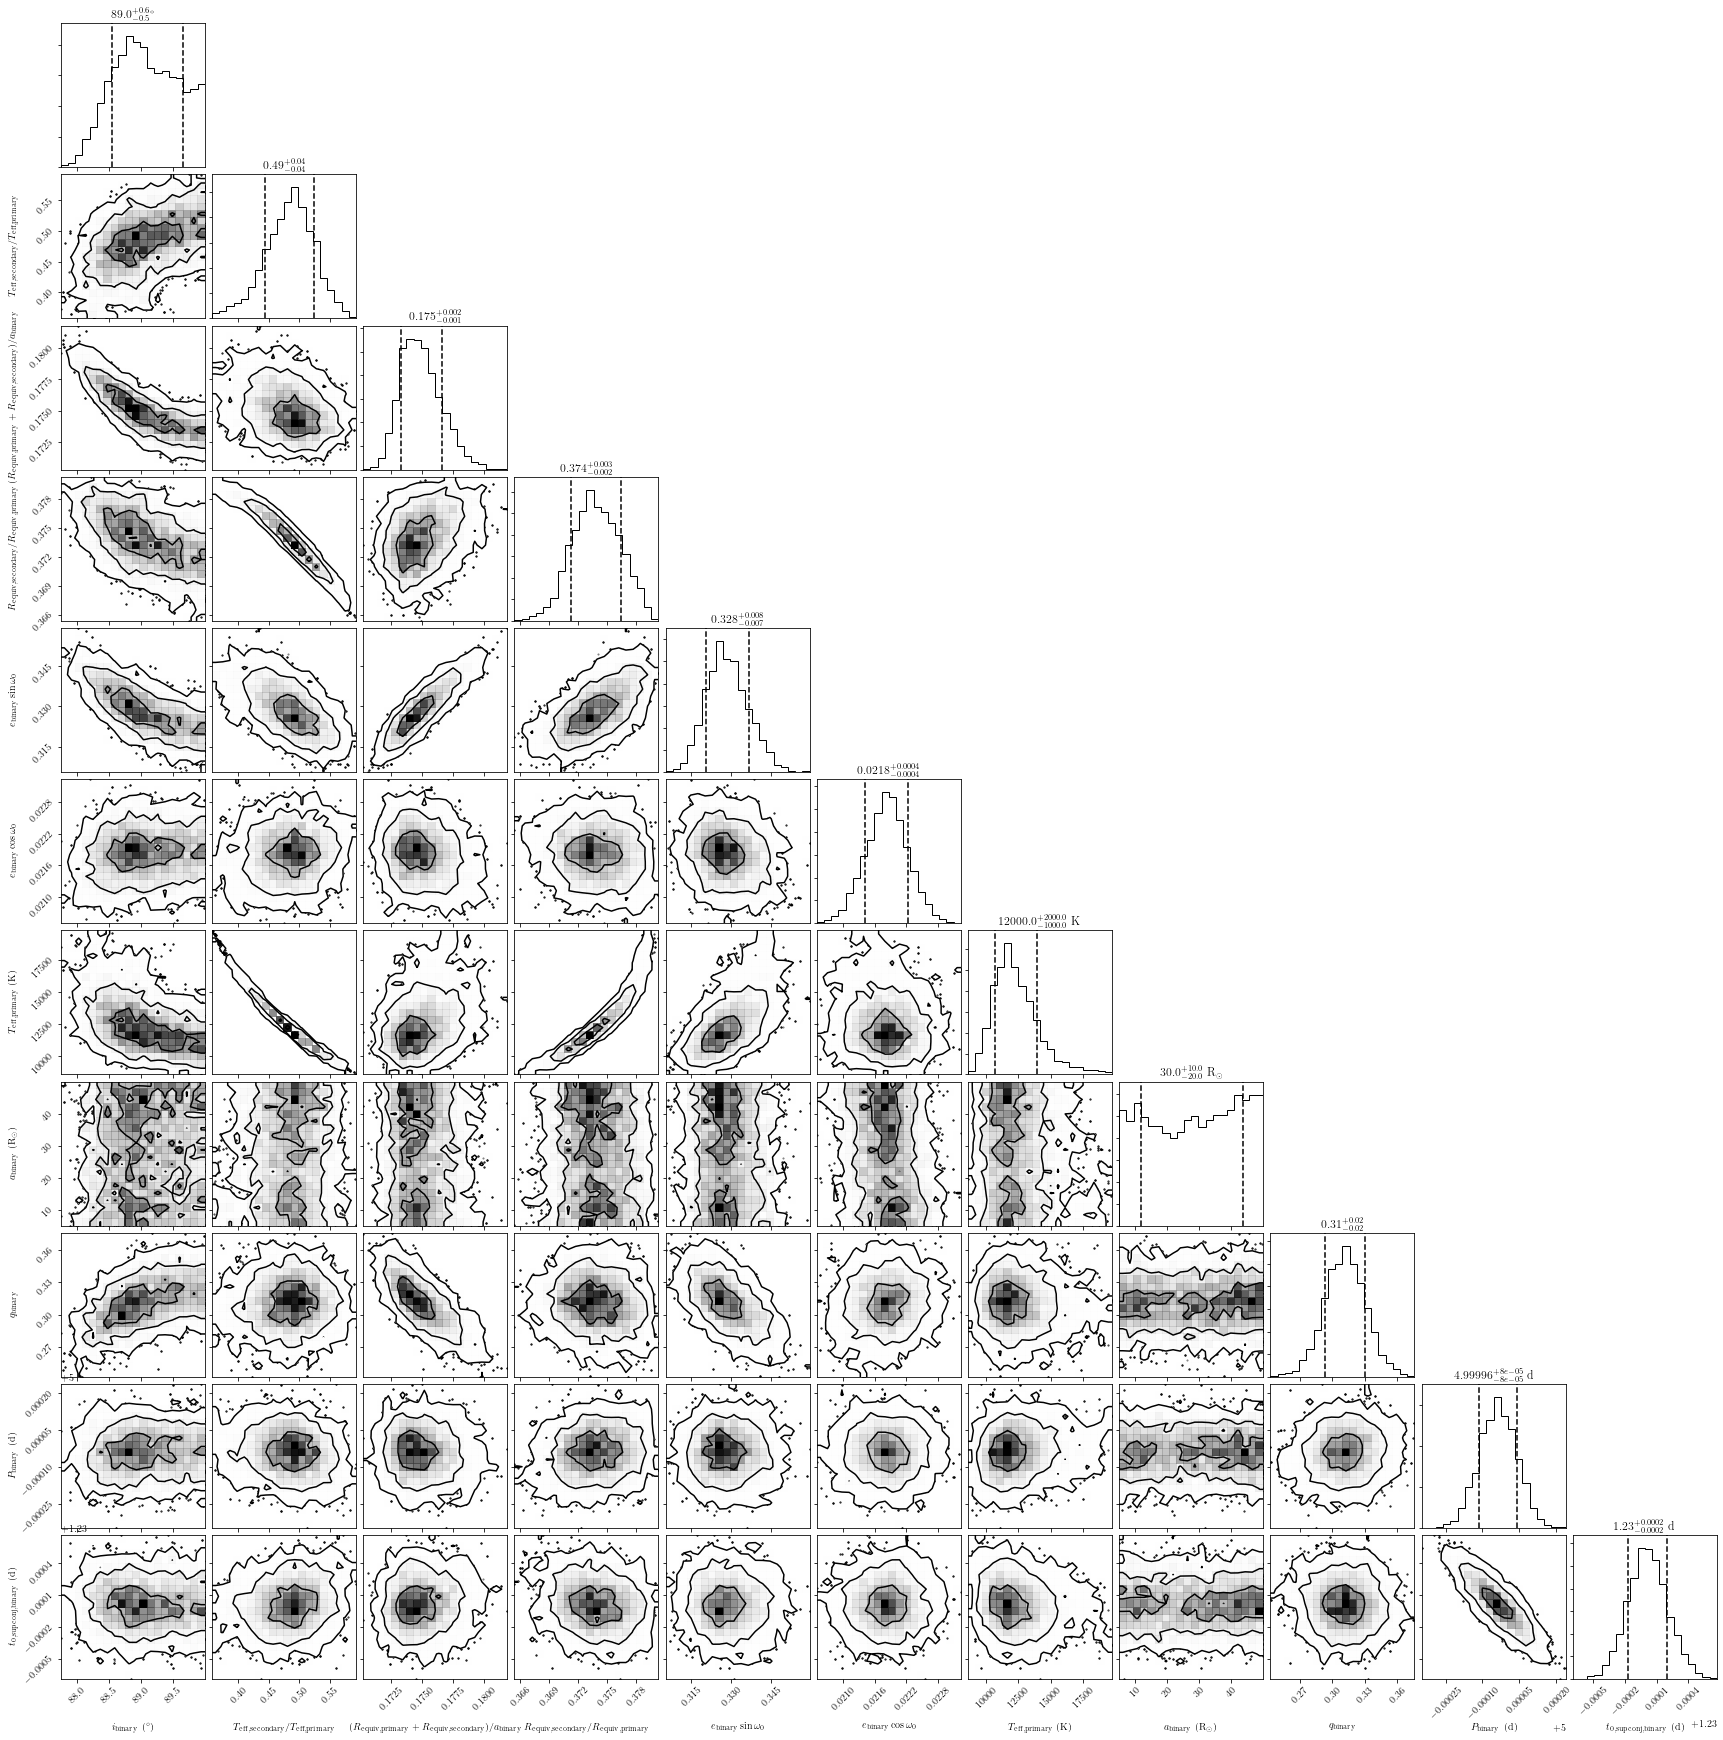

In [225]:
afig, mplfig = b_ce_marg.plot(solution='mcmc_solution', style='corner', burnin=5000, lnprob_cutoff=3145, show=True)
mplfig.savefig('ce_marg_corner.png', dpi=300)

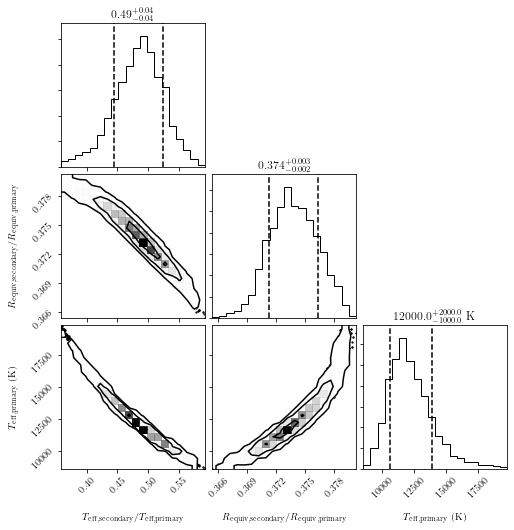

In [229]:
afig, mplfig = b_ce_marg.plot(solution='mcmc_solution', parameters=['teff@primary', 'teffratio', 'requivratio'], style='corner', burnin=5000, lnprob_cutoff=3145, show=True)
mplfig.savefig('ce_corner_teff.png', dpi=300)

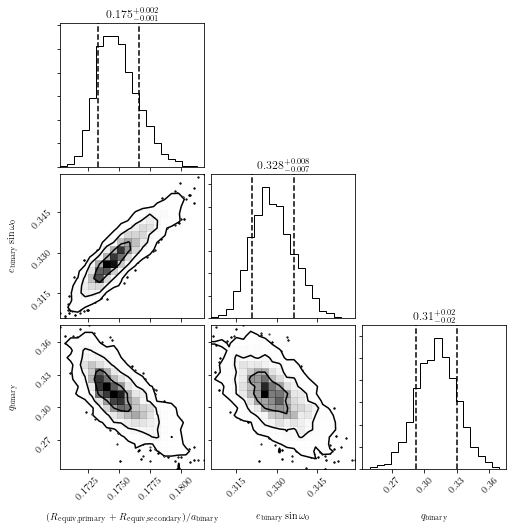

In [233]:
afig, mplfig = b_ce_marg.plot(solution='mcmc_solution', parameters=['q', 'requivsumfrac', 'esinw'], style='corner', burnin=5000, lnprob_cutoff=3145, show=True)
mplfig.savefig('ce_corner_q.png', dpi=300)

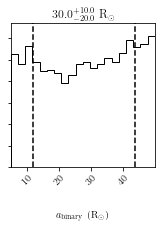

In [232]:
afig, mplfig = b_ce_marg.plot(solution='mcmc_solution', parameters=['sma@binary'], style='corner', burnin=5000, lnprob_cutoff=3145, show=True)
mplfig.savefig('ce_corner_sma.png', dpi=300)

### NUISANCE PARAMETER

In [15]:
#!scp angela@terra.villanova.edu:fitting/phoetting_paper/AAS_ellcbnd/*.py.out.progress data/

In [114]:
%matplotlib qt
bundle_get_dists('ce_noise_corr', 'ce_noise_nogps', plot=True)

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


{'twigs': array(['incl@binary@orbit@component', 'teffratio@binary@orbit@component',
        'requivsumfrac@binary@orbit@component',
        'requivratio@binary@orbit@component',
        'esinw@binary@orbit@component', 'ecosw@binary@orbit@component',
        'teff@primary@star@component', 'q@binary@orbit@component',
        'period@binary@orbit@component',
        't0_supconj@binary@orbit@component', 'sigmas_lnf@lc01@lc@dataset'],
       dtype='<U36'),
 'means': array([ 8.87292144e+01,  4.73079607e-01,  1.77122736e-01,  3.77967263e-01,
         3.34543120e-01,  2.47188067e-02,  1.38983043e+04,  3.41703750e-01,
         5.00040581e+00,  1.22945967e+00, -5.57396886e+00]),
 'errs': array([[1.64166121e+00, 8.96688901e-01],
        [8.03741730e-02, 1.26425351e-01],
        [5.33804112e-03, 7.30341963e-03],
        [7.39702601e-03, 4.62408806e-03],
        [3.17036928e-02, 2.88666588e-02],
        [3.38026752e-03, 2.28188457e-03],
        [4.00979827e+03, 4.37791119e+03],
        [9.91589371e

In [115]:
bundle_get_dists('ce_noise_corr', 'ce_noise_wgps', plot=True)

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


{'twigs': array(['incl@binary@orbit@component', 'teffratio@binary@orbit@component',
        'requivsumfrac@binary@orbit@component',
        'requivratio@binary@orbit@component',
        'esinw@binary@orbit@component', 'ecosw@binary@orbit@component',
        'teff@primary@star@component', 'q@binary@orbit@component',
        'period@binary@orbit@component',
        't0_supconj@binary@orbit@component', 'sigmas_lnf@lc01@lc@dataset',
        'log_rho@gaussian_process01@lc01@gaussian_process@feature',
        'log_sigma@gaussian_process01@lc01@gaussian_process@feature'],
       dtype='<U58'),
 'means': array([ 8.86931837e+01,  5.00981699e-01,  1.75025604e-01,  3.78556282e-01,
         3.34147406e-01,  2.48707813e-02,  1.21692213e+04,  3.72371040e-01,
         5.00037662e+00,  1.22933428e+00, -5.59033249e+00,  7.13822020e+00,
         1.41158400e+00]),
 'errs': array([[3.95042187e+00, 9.14435188e-01],
        [9.99172574e-02, 9.66557375e-02],
        [1.39712805e-02, 6.19727443e-03],
        

In [3]:
%matplotlib inline

In [39]:
def plot_xsection(ax, param1, param2, true_vals, basic, marg, legend=False):
    # get the indices of the parameter values in each solution array
    i1 = np.argwhere(basic['twigs']==param1).flatten()[0]
    j1 = np.argwhere(basic['twigs']==param2).flatten()[0]
    i2 = np.argwhere(marg['twigs']==param1).flatten()[0]
    j2 = np.argwhere(marg['twigs']==param2).flatten()[0]
    
    ax.scatter(true_vals[i1], true_vals[j1], marker='x', s=100, c=cs['black'], label='true')
    
    for i,j,sol,c,label in zip([i1,i2],
                             [j1,j2],
                             [basic,marg],
                            [cs['blue'], cs['green']],
                              ['no GPs', 'with GPs']):
        ax.errorbar(x=sol['means'][i], y=sol['means'][j], 
                    xerr=[[sol['errs'][i][0]], [sol['errs'][i][1]]], 
                    yerr=[[sol['errs'][j][0]], [sol['errs'][j][1]]], 
                    fmt='o', ms=10, ls='none', c=c, label=label)
    
    if legend:
        ax.legend(loc='lower right')
        
        
    return ax


In [40]:
b_ng, ce_basic = bundle_get_dists('ce_noise_corr', 'ce_noise_nogps', lnprob_cutoff=2390, plot=False)

In [41]:
b_g, ce_marg = bundle_get_dists('ce_noise_corr', 'ce_noise_wgps', lnprob_cutoff=2400, plot=False)

In [42]:
true_vals = bundle_get_true('d_ce', ce_basic['twigs'][:8])

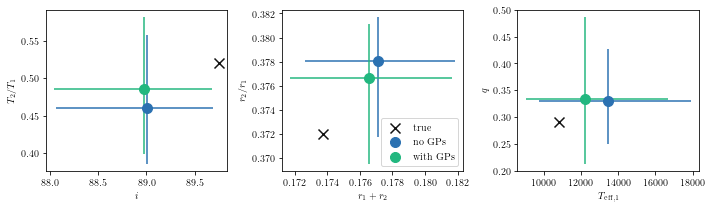

In [43]:
params = ce_basic['twigs']
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
plot_xsection(ax1, params[0], params[1], 
              true_vals, ce_basic, ce_marg)
plot_xsection(ax2, params[2], params[3], 
              true_vals, ce_basic, ce_marg, legend=True)
plot_xsection(ax3, params[6], params[7], 
              true_vals, ce_basic, ce_marg)
ax1.set_xlabel('$i$')
ax1.set_ylabel('$T_2/T_1$')
ax2.set_xlabel('$r_1+r_2$')
ax2.set_ylabel('$r_2/r_1$')
ax3.set_xlabel('$T_{\mathrm{eff},1}$')
ax3.set_ylabel('$q$')
fig.tight_layout()
fig.savefig('figs/gps3.png', dpi=300)

In [44]:
def plot_xsection(ax, param1, param2, true_vals, basic, marg, legend=False):
    # get the indices of the parameter values in each solution array
    i1 = np.argwhere(basic['twigs']==param1).flatten()[0]
    j1 = np.argwhere(basic['twigs']==param2).flatten()[0]
    i2 = np.argwhere(marg['twigs']==param1).flatten()[0]
    j2 = np.argwhere(marg['twigs']==param2).flatten()[0]
    
    ax.scatter(true_vals[i1], true_vals[j1], marker='x', s=100, c=cs['black'], label='true')
    
    for i,j,sol,c,label in zip([i1,i2],
                             [j1,j2],
                             [basic,marg],
                            [cs['blue'], cs['green']],
                              ['no $\sigma_{\ln f}$', 'with $\sigma_{\ln f}$']):
        ax.errorbar(x=sol['means'][i], y=sol['means'][j], 
                    xerr=[[sol['errs'][i][0]], [sol['errs'][i][1]]], 
                    yerr=[[sol['errs'][j][0]], [sol['errs'][j][1]]], 
                    fmt='o', ms=10, ls='none', c=c, label=label)
    
    if legend:
        ax.legend(loc='lower right')
        
        
    return ax


In [45]:
b_ng, ce_basic = bundle_get_dists('ce_noise', 'ce_noise_nonuis', lnprob_cutoff=2280, plot=False)

In [46]:
b_g, ce_marg = bundle_get_dists('ce_noise', 'ce_noise_wnuis', lnprob_cutoff=2385, plot=False)

In [47]:
true_vals = bundle_get_true('d_ce', ce_basic['twigs'][:8])

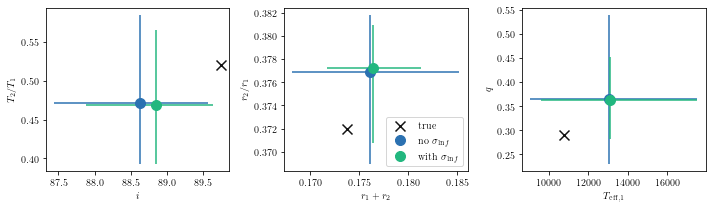

In [48]:
params = ce_basic['twigs']
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
plot_xsection(ax1, params[0], params[1], 
              true_vals, ce_basic, ce_marg)
plot_xsection(ax2, params[2], params[3], 
              true_vals, ce_basic, ce_marg, legend=True)
plot_xsection(ax3, params[6], params[7], 
              true_vals, ce_basic, ce_marg)
ax1.set_xlabel('$i$')
ax1.set_ylabel('$T_2/T_1$')
ax2.set_xlabel('$r_1+r_2$')
ax2.set_ylabel('$r_2/r_1$')
ax3.set_xlabel('$T_{\mathrm{eff},1}$')
ax3.set_ylabel('$q$')
fig.tight_layout()
fig.savefig('figs/nuis3.png', dpi=300)